# Short Term Risk Prediction With XGBoost

In this notebook we try and predict readmission in less than 30 days using data created in the Feature Engineering notebook.

In [1]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import scikitplot as skplt
import time
import pickle

os.environ["OMP_NUM_THREADS"] = "8"

TRAIN = True

In [2]:
df = pd.read_csv("Clean_Data_v2.csv")

In [3]:
df.shape

(69879, 125)

In [4]:
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_17,admission_source_id_20,admission_source_id_22,admission_source_id_25
0,0,1,41,0,1,0,0,0,1,NaN,...,0,0,0,0,0,0,0,0,0,0
1,10,3,59,0,18,0,0,0,9,NaN,...,0,0,0,0,0,0,0,0,0,0
2,20,2,11,5,13,2,0,1,6,NaN,...,0,0,0,0,0,0,0,0,0,0
3,30,2,44,1,16,0,0,0,7,NaN,...,0,0,0,0,0,0,0,0,0,0
4,40,1,51,0,8,0,0,0,5,NaN,...,0,0,0,0,0,0,0,0,0,0


# Train Test Split

In [9]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['within30']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5, stratify=y)

Examples in training:

In [10]:
y_train.value_counts()

0    46658
1     2257
Name: within30, dtype: int64

Examples in testing:

In [11]:
y_test.value_counts()

0    19997
1      967
Name: within30, dtype: int64

In both cases, the proportion of classes in the same.

In [12]:
y_test.value_counts()[0] / y_test.value_counts()[1]

20.6794208893485

# Dealing With Class Imbalance

## Grid Search For Hyperparameters

Note that we are not using classification error for the evaluation metric because we would get "good" results from just choosing the negative class all the time. Instead, we use the auc curve so we need to perform well on the positive and negative cases.

In [189]:
scale_pos_weight = y_test.value_counts()[0] / y_test.value_counts()[1]

# First, I want to figure out the main bias variance tradeoff parameters: max_depth, n_estimators, learning_rate

model = XGBClassifier(n_jobs=8)
param_grid = {
    'max_depth': [3, 6, 8, 12],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.03],
    'scale_pos_weight': [18, 20, 22],
    'min_child_weight': [1, 3, 5]
}

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=5)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=8, max_depth=6, subsample=0.9, colsample_bylevel=0.9, colsample_bytree=0.9, n_estimators=100, learning_rate=0.1)
#model = XGBClassifier(scale_pos_weight=3, n_jobs=8, max_depth=3, subsample=0.8, colsample_bylevel=0.8, colsample_bytree=0.8, n_estimators=1000, learning_rate=0.001)
#model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=8, max_depth=8, n_estimators=1000, learning_rate=0.1)
#start = time.time()
#model.fit(X_train, y_train, verbose=True)
#elapsed = time.time() - start
#print(elapsed)


Best: 0.668549 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1}


## Train A Model With Best Hyperparameters

In [73]:
model = XGBClassifier(n_jobs=8, learning_rate=0.1, max_depth=3, n_estimators=300, scale_pos_weight=20)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

In [74]:
y_train_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 74.22%


## Accuracy

In [75]:
# make predictions for test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.48%


In [25]:
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [26]:
np.sum(y_pred)

5732

In [70]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  14768
False Positives:  5229
False Negatives:  415
True Positives:  552


In [76]:
def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)

precision = compute_precision(tp, fp)
recall = compute_recall(tp, fn)

print('Precision: {0:.2f}\n\nRecall: {1:.2f}'.format(precision, recall))

Precision: 0.10

Recall: 0.57


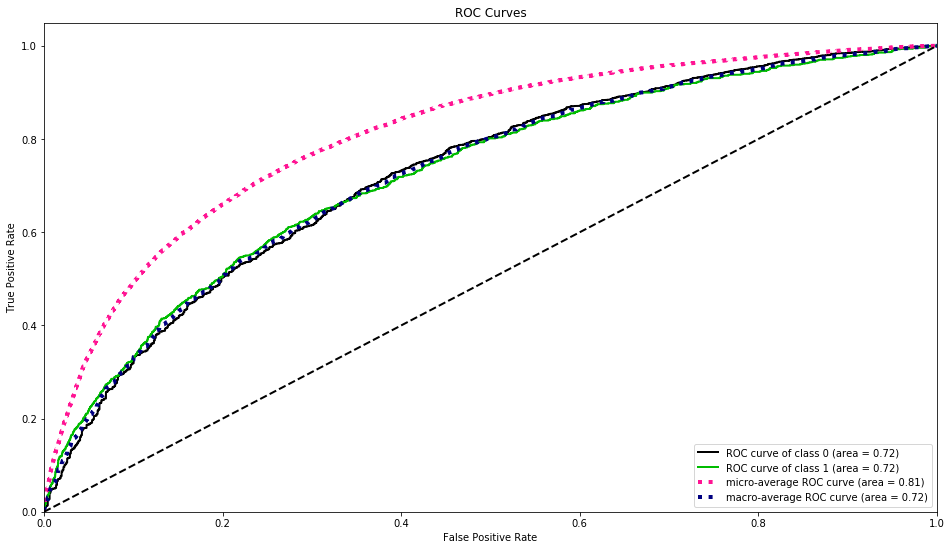

In [77]:
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()


The performance is not very good in general on both classes. The micro average being high suggests that we are performing well on the majority class but the macro average being low suggests we are not performing well on the minority class.

## Serialize model

In [201]:
pickle.dump(model, open("short_term_xgboost_v1.pickle.dat", "wb"))

## Feature Importance

It is clear that we need to do some more feature engineering because even after doing a lot of hyperparameter tuning we are not getting good performance. I want to see what features are important in this model in case I end up messing with an important feature during my engineering.

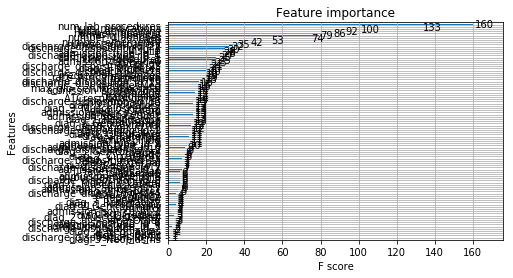

In [23]:
plot_importance(model)
plt.show()

There are a lot of features here but we can limit the number of features because it appears that only the top few are important.

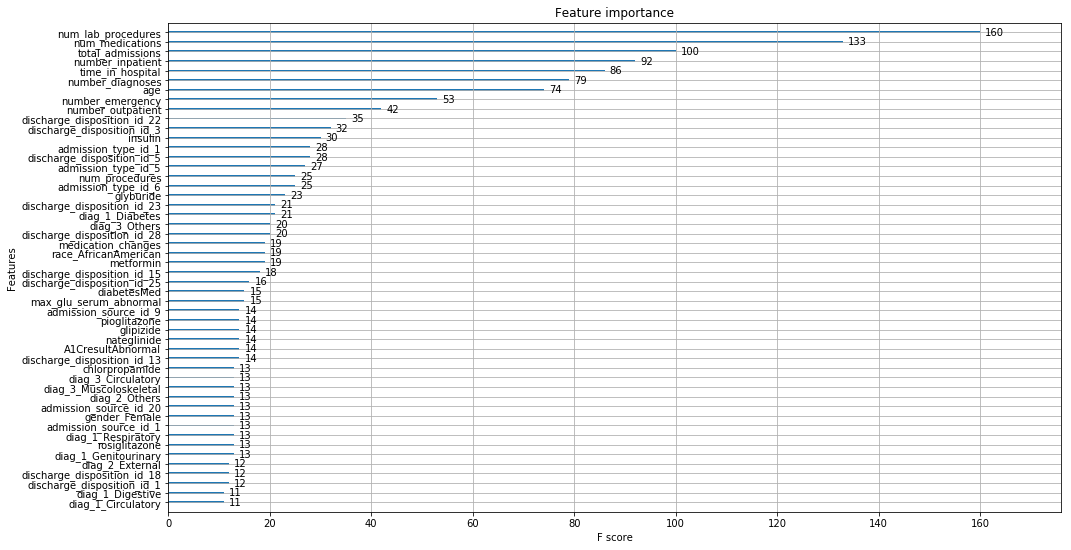

In [24]:
plt.rcParams["figure.figsize"] = [16,9]
plot_importance(model, max_num_features=50)
plt.show()
